# 5.4 컨브넷 학습 시각화

컨브넷의 표현들을 시각화하고 해석하는 다양한 기법들이 개발되었습니다.
- 컨브넷 중간층의 출력(중간층에 있는 활성화)을 시각화하기
- 컨브넷 필터를 시각화하기
- 클래스 활성화에 대한 히트맵을 이미지에 시각화하기

### 5.4.1 중간층의 활성화 시각화하기

In [3]:
from keras.models import load_model
model = load_model('cats_and_dogs_small_2.h5')
model.summary()

KeyError: 0

AttributeError: 'str' object has no attribute 'decode' 에러 발생해서

```pip install h5py==2.10.0```

로 설치 했으나 KeyError: 0 발생한다

#### 코드 5-25 개별 이미지 전처리하기

In [5]:
img_path = './datasets/cats_and_dogs_small/test/cats/cat.1700.jpg'

from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

print(img_tensor.shape)

(1, 150, 150, 3)


#### 코드 5-26 테스트 사진 출력하기

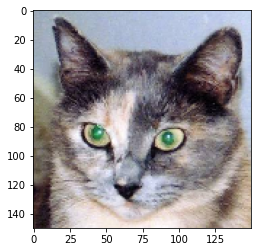

In [6]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

확인하고 싶은 특성 맵을 추출하기 위해 이미지 배치를 입력으로 받아 모든 합성곱과 풀링 층의 활성화를 출력하는 케라스 모델을 만들 것입니다. 이를 위해 케라스의 Model 클래스를 사용하겠습니다. 모델 객체를 만들 때 2개의 매개변수가 필요합니다. 입력 텐서(또는 입력 텐서의 리스트)와 출력 텐서(또는 출력 텐서의 리스트)입니다. 반환되는 객체는 Sequential과 같은 케라스 모델이지만 특정 입력과 특정 출력을 매핑합니다. Model 클래스를 사용하면 Sequential과는 달리 여러개의 출력을 가진 모델을 만들 수 있습니다.

#### 코드 5-27 입력 텐서와 출력 텐서의 리스트로 모델 객체 만들기

In [7]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

NameError: name 'model' is not defined

#### 코드 5-28 예측 모드로 모델 실행하기

In [8]:
activations = activation_model.predict(img_tensor)

NameError: name 'activation_model' is not defined

예를 들어 다음이 고양이 이미지에 대한 첫 번째 합성곱 층의 활성화 값입니다.

In [9]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

NameError: name 'activations' is not defined

32개의 채널을 가진 148×148 크기의 특성 맵입니다.

#### 코드 5-29 20번째 채널 시각화하기

In [10]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 19], cmap='viridis')

NameError: name 'first_layer_activation' is not defined

#### 코드 5-30 16번째 채널 시각화하기

In [11]:
plt.matshow(first_layer_activation[0, :, :, 15], cmap='viridis')

NameError: name 'first_layer_activation' is not defined

#### 코드 5-31 중간층의 모든 활성화에 있는 채널 시각화하기

In [12]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    
    size = layer_activation.shape[1]
    
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                            :, :,
                                            col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                        row * size : (row + 1) * size] = channel_image
            
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                       scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

NameError: name 'model' is not defined

몇 가지 주목할 내용이 있습니다.
- 첫 번째 층은 여러 종류의 에지 감지기를 모아 놓은 것 같습니다.
- 상위 층으로 갈수록 활성화는 점점 더 추상적으로 되고 시각적으로 이해하기 어려워집니다. 상위 층의 표현은 이미지의 시각적 콘텐츠에 관한 정보가 점점 줄어들고 이미지의 클래스에 관한 정보가 점점 증가합니다.
- 비어 있는 활성화가 층이 깊어짐에 따라 늘어납니다.

### 5.4.2 컨브넷 필터 시각화하기

컨브넷이 학습한 필터를 조사하는 또 다른 방법은 각 필터가 반응하는 시각적 패턴을 그려 보는 것입니다.

#### 코드 5-32 필터 시각화를 위한 손실 텐서 정의하기

In [13]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
             include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

경사 상승법을 구현하기 위해 모델의 입력에 대한 손실의 그래디언트가 필요합니다. 이를 위해 케라스의 backend 모듈에 있는 gradients 함수를 사용하겠습니다.

#### 코드 5-33 입력에 대한 손실의 그래디언트 구하기

In [14]:
grads = K.gradients(loss, model.input)[0]

경사 상승법 과정을 부드럽게 하기 위해 사용하는 한 가지 기법은 그래디언트 텐서를 L2 노름으로 나누어 정규화하는 것입니다.

#### 코드 5-32 그래디언트 정규화하기

In [15]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

#### 코드 5-35 입력 값에 대한 넘파이 출력 값 추출하기

In [16]:
iterate = K.function([model.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

#### 코드 5-36 확률적 경사 상승법을 사용한 손실 최대화하기

In [18]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    
    input_img_data += grads_value * step

결과 이미지 텐서는 (1, 150, 150, 3) 크기의 부동 소수 텐서입니다. 이 텐서 값은 [0, 255] 사이의 정수가 아닙니다. 따라서 출력 가능한 이미지로 변경하기 위해 후처리할 필요가 있습니다.

#### 코드 5-37 텐서를 이미지 형태로 변환하기 위한 유틸리티 함수

In [19]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

#### 코드 5-38 필터 시각화 이미지를 만드는 함수

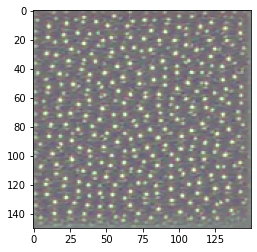

In [20]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    grads = K.gradients(loss, model.input)[0]
    
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    step = 1
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    
    img = input_img_data[0]
    return deprocess_image(img)

plt.imshow(generate_pattern('block3_conv1', 0))

block3_conv1 층의 필터 0은 물방울 패턴에 반응하는 것 같습니다. 모든 층에 있는 필터를 시각화해 보겠습니다.

#### 코드 5-39 층에 있는 각 필터에 반응하는 패턴 생성하기

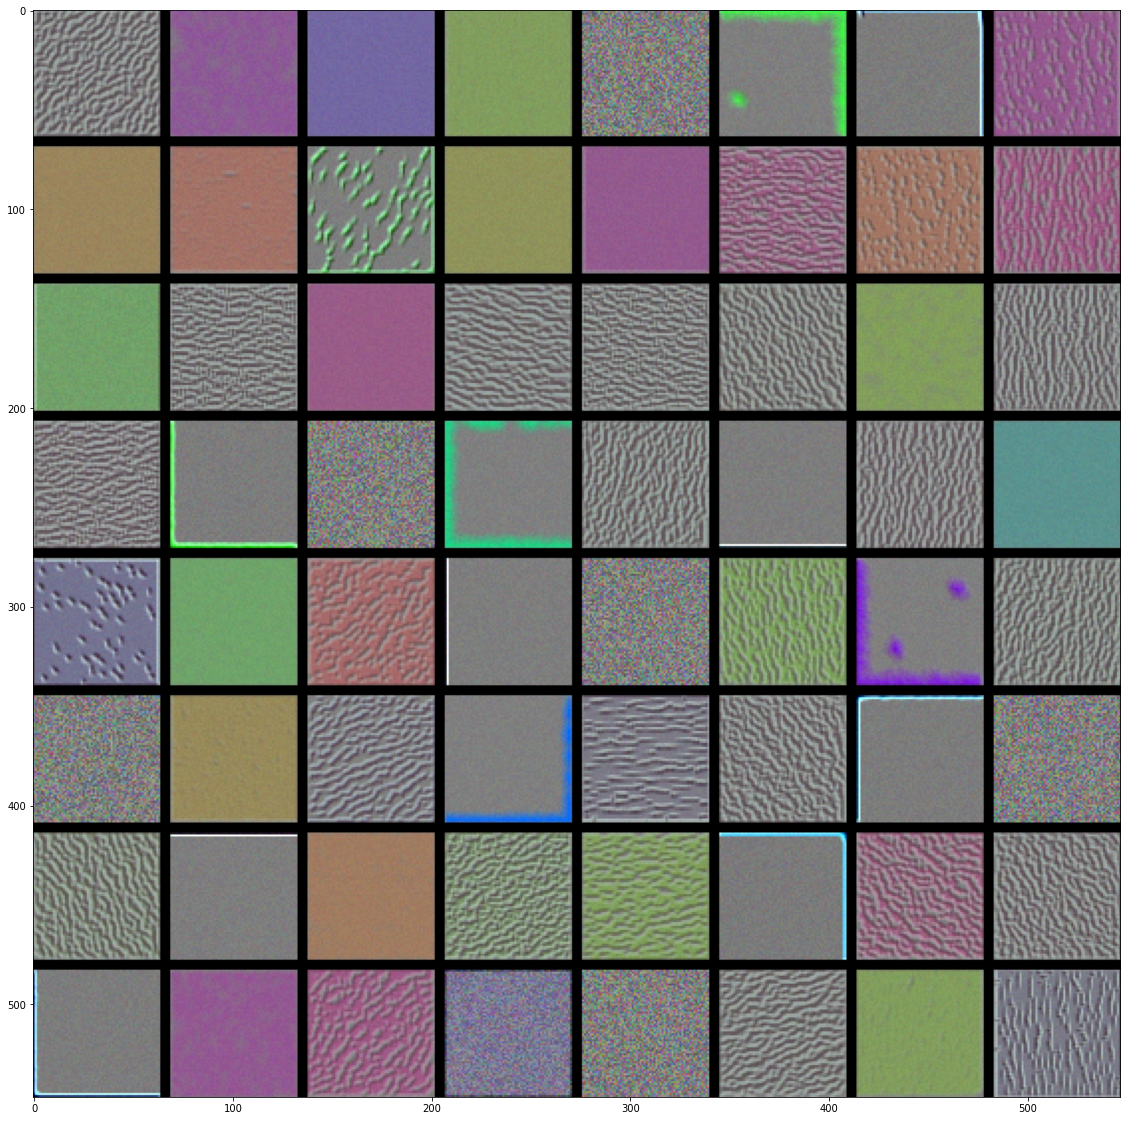

In [21]:
layer_name = 'block1_conv1'
size = 64
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3), dtype='uint8')

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img
        
plt.figure(figsize=(20, 20))
plt.imshow(results)

이런 필터 시각화를 통해컨브넷 층이 바라보는 방식을 이해할 수 있습니다. 컨브넷의 각 층은 필터의 조합으로 입력을 표현할 수 있는 일련의 필터를 학습합니다.

### 5.4.3 클래스 활성화의 히트맵 시각화하기
이 기법의 종류를 일반적으로 클래스 활성화 맵(Class Activation Map, CAM) 시각화라고 부릅니다. 클래스 활성화 히트맵은 특정 출력 클래스에 대해 입력 이미지의 모든 위치를 계산한 2D 점수 그리드입니다. 클래스에 대해 각 위치가 얼마나 중요한지 알려줍니다.

#### 코드 5-40 사전 훈련된 가중치로 VGG16 네트워크 로드하기

In [22]:
from keras.applications.vgg16 import VGG16

model = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 11s 0us/step


#### 코드 5-41 VGG16을 위해 입력 이미지 전처리하기

In [24]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = './datasets/creative_commons_elephant.jpg'

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)

x = np.expand_dims(x, axis=0)

x = preprocess_input(x)

이제 이 이미지에서 사전 훈련된 네트워크를 실행하고 예측 벡터를 이해하기 쉽게 디코딩합니다.

In [25]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 5us/step
Predicted: [('n02504458', 'African_elephant', 0.90988606), ('n01871265', 'tusker', 0.08572466), ('n02504013', 'Indian_elephant', 0.0043471223)]


이 이미지에 대한 상위 3개의 예측 클래스는 다음과 같습니다.
- 아프리카 코끼리(92.5% 확률)
- 코끼리(7% 확률)
- 인도 코끼리(0.4% 확률)

예측 벡터에서 최대로 활성화된 항목은 '아프리카 코끼리' 클래스에 대한 것으로 386번 인덱스입니다.

In [26]:
np.argmax(preds[0])

386

이미지에서 가장 아프리카 코끼리 같은 부위를 시각화하기 위해 Grad-CAM 처리 과정을 구현하겠습니다.

#### 코드 5-42 Grad-CAM 알고리즘 설정하기

In [28]:
african_elephant_output = model.output[:, 386]  # 예측 벡터의 '아프리카 코끼리' 항목

last_conv_layer = model.get_layer('block5_conv3')  # VGG16의 마지막 합성곱 층인 block5_conv3 층의 특성 맵
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]  ## block5_conv3의 특성 맵 출력에 대한 '아프리카 코끼리' 클래스의 그래디언트
pooled_grads = K.mean(grads, axis=(0, 1, 2))  # 특성 맵 채널별 그래디언트 평균값이 담긴 (512,) 크기의 벡터

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])  # 샘플 이미지가 주어졌을 때 방금 전 정의한 pooled_grads와 block5_conv3의 특성 맵 출력을 구합니다.
pooled_grads_value, conv_layer_output_value = iterate([x])  # 두 마리 코끼리가 있는 샘플 이미지를 주입하고 2개의 넘파이 배열을 얻습니다.

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]  # "아프리카 코끼리" 클래스에 대한 "채널의 중요도"를 특성 맵 배열의 채널에 곱합니다.

heatmap = np.mean(conv_layer_output_value, axis=-1)  # 만들어진 특성 맵에서 채널 축을 따라 평균한 값이 클래스 활성화의 히트맵입니다.

#### 코드 5-43 히트맵 후처리하기

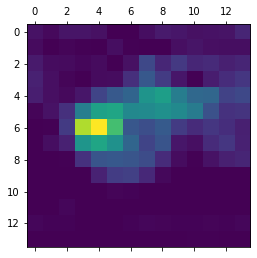

In [29]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

#### 코드 5-44 원본 이미지에 히트맵 덧붙이기

아래를 먼저 설치한다.

```pip install opencv-python```

In [31]:
import cv2

img = cv2.imread(img_path)  # cv2 모듈을 사용하여 원본 이미지를 로드합니다.

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))  # heatmap을 원본 이미지 크기에 맞게 변경합니다.

heatmap = np.uint8(255 * heatmap)  # heatmap을 RGB 포맷으로 변환합니다.

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # 히트맵으로 변환합니다.

superimposed_img = heatmap * 0.4 + img  # 0.4는 히트맵의 강도입니다.

cv2.imwrite('./datasets/elephant_cam.jpg', superimposed_img)  # 디스크에 이미지를 저장합니다.

True

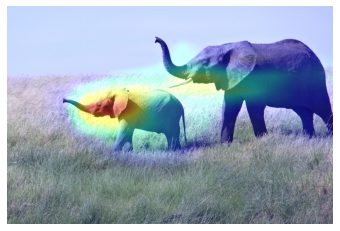

In [34]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 저장한 이미지 경로
img_path = './datasets/elephant_cam.jpg'

# 이미지 표시
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')  # 이미지 축을 끄려면 이 줄을 추가합니다.
plt.show()